In [25]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from keras.callbacks import EarlyStopping,ModelCheckpoint


In [38]:
import os
from collections import Counter

data_dir = "C:/Users/DM/Documents/yh/AIFFEL/Exploration/data/flower_photos"
class_counts = {}

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
        class_counts[class_name] = count

# 결과 출력
total = sum(class_counts.values())
for cls, count in class_counts.items():
    print(f"{cls}: {count} images ({count/total:.2%})")


daisy: 633 images (17.25%)
dandelion: 898 images (24.47%)
roses: 641 images (17.47%)
sunflowers: 699 images (19.05%)
tulips: 799 images (21.77%)


In [26]:
batch_size = 32
img_height = 224
img_width = 224

data_dir = "C:/Users/DM/Documents/yh/AIFFEL/Exploration/data/flower_photos"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# 절반 나누기: val/test 10%씩
val_batches = tf.data.experimental.cardinality(val_test_ds).numpy() // 2
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [36]:
import collections
import numpy as np

def count_class_distribution(dataset, class_names):
    label_counts = collections.Counter()

    for images, labels in dataset:
        labels = labels.numpy()
        label_counts.update(labels)

    # 보기 좋게 정리
    for label_index, count in sorted(label_counts.items()):
        class_name = class_names[label_index]
        print(f"{class_name}: {count}")

    return label_counts

# 클래스 이름 가져오기
class_names = train_ds.class_names  # ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

print("🔎 training Set Class Distribution:")
train_distribution = count_class_distribution(train_ds, class_names)

print("🔎 Validation Set Class Distribution:")
val_distribution = count_class_distribution(val_ds, class_names)

print("\n🔎 Test Set Class Distribution:")
test_distribution = count_class_distribution(test_ds, class_names)


🔎 training Set Class Distribution:
daisy: 504
dandelion: 722
roses: 521
sunflowers: 547
tulips: 642
🔎 Validation Set Class Distribution:
daisy: 63
dandelion: 84
roses: 49
sunflowers: 77
tulips: 79

🔎 Test Set Class Distribution:
daisy: 67
dandelion: 88
roses: 61
sunflowers: 80
tulips: 86


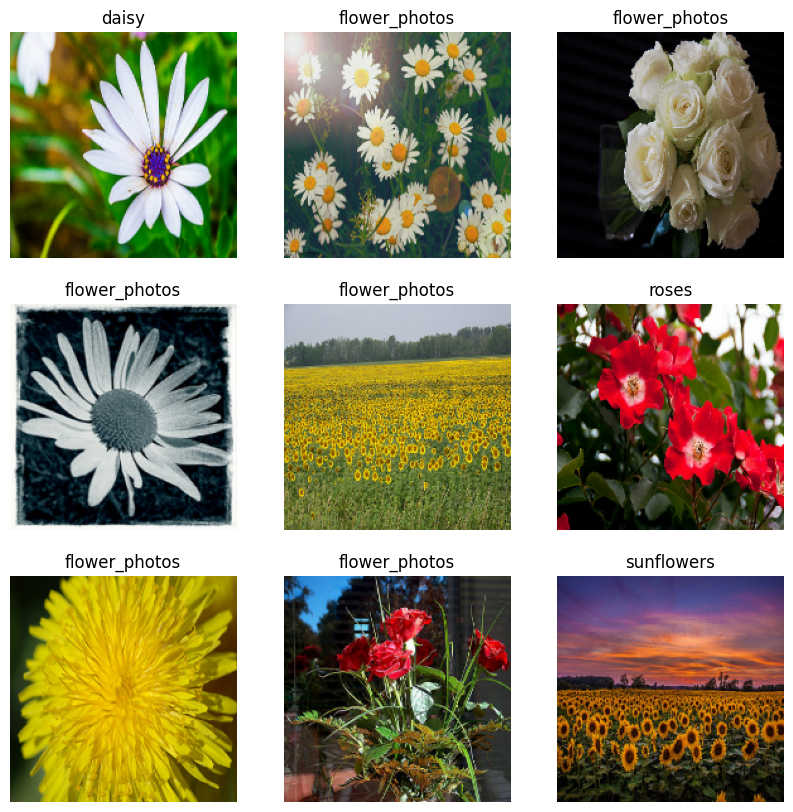

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 1) VGG-16

In [11]:
from tensorflow.keras import layers, models

input_layer = layers.Input(shape=(160, 160, 3))
x = layers.Rescaling(1./255)(input_layer)

# Conv Block 1
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Conv Block 2
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Conv Block 3
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Conv Block 4 (선택)
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

# FC Layer
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output Layer (6-class)
output_layer = layers.Dense(6, activation='softmax')(x)

# 모델 정의
model = models.Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 160, 160, 32)      896       
                                                                 
 conv2d_8 (Conv2D)           (None, 160, 160, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 80, 80, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 80, 80, 64)        36928     
                                                           

In [12]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


184/184 [==============================] - 213s 1s/step - loss: 1.6330 - accuracy: 0.4896 - val_loss: 1.5811 - val_accuracy: 0.5027
Epoch 2/10
184/184 [==============================] - 219s 1s/step - loss: 1.5291 - accuracy: 0.4969 - val_loss: 1.4615 - val_accuracy: 0.5231
Epoch 3/10
184/184 [==============================] - 218s 1s/step - loss: 1.4334 - accuracy: 0.4898 - val_loss: 1.3899 - val_accuracy: 0.5149
Epoch 4/10
184/184 [==============================] - 233s 1s/step - loss: 1.3163 - accuracy: 0.4877 - val_loss: 1.2479 - val_accuracy: 0.5109
Epoch 5/10
184/184 [==============================] - 213s 1s/step - loss: 1.2743 - accuracy: 0.4865 - val_loss: 1.1822 - val_accuracy: 0.5163
Epoch 6/10
184/184 [==============================] - 226s 1s/step - loss: 1.2297 - accuracy: 0.4886 - val_loss: 1.1405 - val_accuracy: 0.5000
Epoch 7/10
 48/184 [======>.......................] - ETA: 2:37 - loss: 1.1751 - accuracy: 0.5007

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Accuracy: {test_acc:.4f}")
print(f"Loss: {test_loss:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.4877 - loss: 1.1096
✅ 테스트 정확도: 0.4959
✅ 테스트 손실값: 1.1235


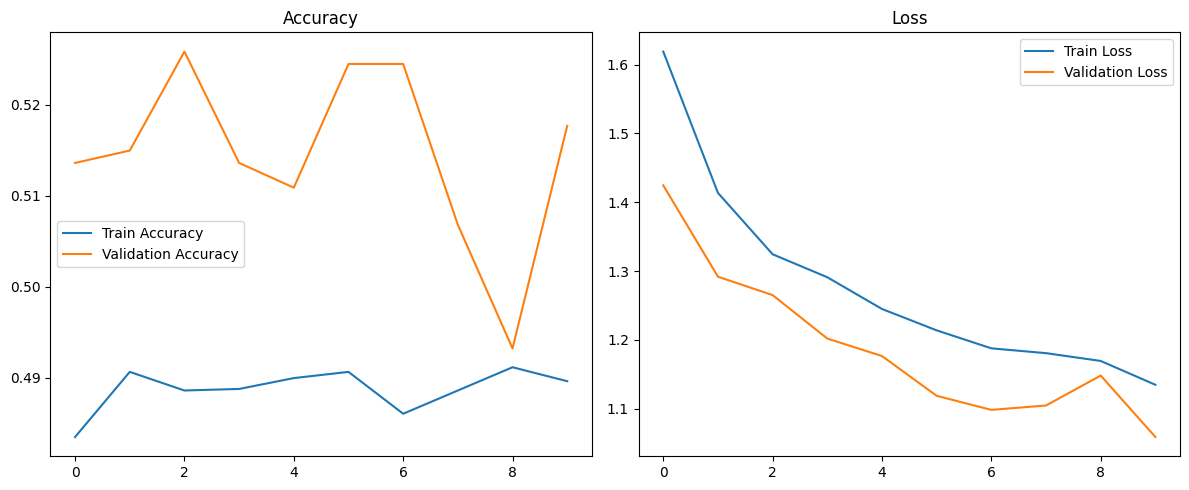

In [34]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### 2) pre_trained

### MobileNet
- 앱 구현을 위해 가벼운 MobileNet 선정함

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import tensorflow as tf

data_augmentation = tf.keras.Sequential([  # 이미지 개수가 적어 성능이 좋지 않았음. 따라서 이미지 증강 적용
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Pre-trained MobileNetV2 
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Feature extractor로 사용

inputs = layers.Input(shape=(224, 224, 3)) # 이미지 160, 180 등 다양하게 적용하였으나, 모바일 넷에서 주로 활용하는 224x224 사용
x = data_augmentation(inputs)  # 증강 적용
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)  # 전처리
x = base_model(x, training=False)  # 증강된 이미지 입력
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation='softmax')(x)

mobilenet_model = models.Model(inputs, outputs)


# 모델 요약
mobilenet_model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
checkpoint =ModelCheckpoint("mobilenet_model.h5", save_best_only=True) # 추후 앱 구현을 위한 h5
early_stopping =EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
from tensorflow.keras.optimizers import Adam

custom_adam = Adam(learning_rate=1e-4) # lms 노드는 구 버전인 것 같아 최신 Adam 사용, 전이 학습시 사용하는 일반적 learning_rate 사용

mobilenet_model.compile(optimizer =custom_adam,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

mobile_hist = mobilenet_model.fit(
    train_ds,                
    epochs=30, # 10에폭으로 시작하였으나, 학습 성능이 충분히 향상되는 경향이 있어 30에폭 설정
    validation_data=val_ds,
    callbacks=[checkpoint,early_stopping]
)



Epoch 1/30


92/92 [==============================] - 52s 523ms/step - loss: 1.7026 - accuracy: 0.4193 - val_loss: 0.8058 - val_accuracy: 0.7273
Epoch 2/30
92/92 [==============================] - 47s 509ms/step - loss: 0.9865 - accuracy: 0.6608 - val_loss: 0.6123 - val_accuracy: 0.7983
Epoch 3/30
92/92 [==============================] - 48s 526ms/step - loss: 0.7663 - accuracy: 0.7435 - val_loss: 0.4883 - val_accuracy: 0.8210
Epoch 4/30
92/92 [==============================] - 48s 525ms/step - loss: 0.6503 - accuracy: 0.7766 - val_loss: 0.4542 - val_accuracy: 0.8438
Epoch 5/30
92/92 [==============================] - 48s 524ms/step - loss: 0.5864 - accuracy: 0.7933 - val_loss: 0.3834 - val_accuracy: 0.8523
Epoch 6/30
92/92 [==============================] - 48s 525ms/step - loss: 0.5269 - accuracy: 0.8059 - val_loss: 0.3867 - val_accuracy: 0.8523
Epoch 7/30
92/92 [==============================] - 48s 521ms/step - loss: 0.4922 - accuracy: 0.8215 - val_loss: 0.3917 - val_accuracy: 0.8693
Epoch 8/30

In [42]:
test_loss, test_acc = mobilenet_model.evaluate(test_ds)
print(f"Accuracy: {test_acc:.4f}")
print(f"Loss: {test_loss:.4f}")

12/12 [==============================] - 5s 394ms/step - loss: 0.2792 - accuracy: 0.9058
Accuracy: 0.9058
Loss: 0.2792


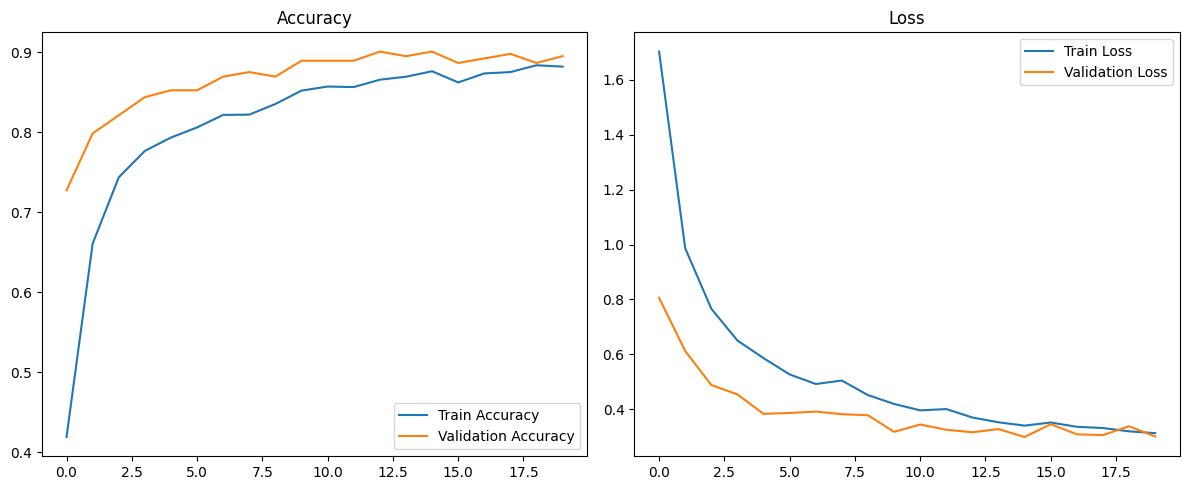

In [44]:
import matplotlib.pyplot as plt

acc = mobile_hist.history['accuracy']
val_acc = mobile_hist.history['val_accuracy']
loss = mobile_hist.history['loss']
val_loss = mobile_hist.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 1s/step


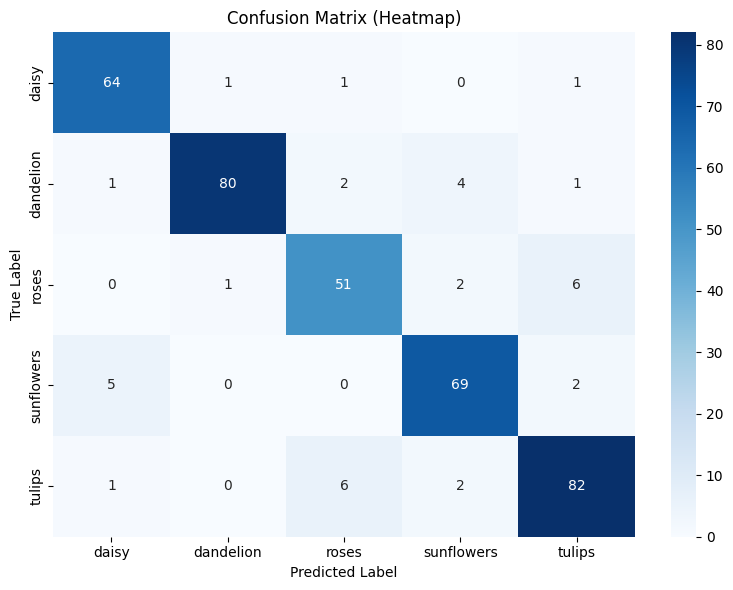

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 클래스 이름 (train_ds에서 가져오기)
class_names = train_ds.class_names

# 예측 결과 수집
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = mobilenet_model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels.numpy())

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)

# 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Heatmap)')
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 391ms/step


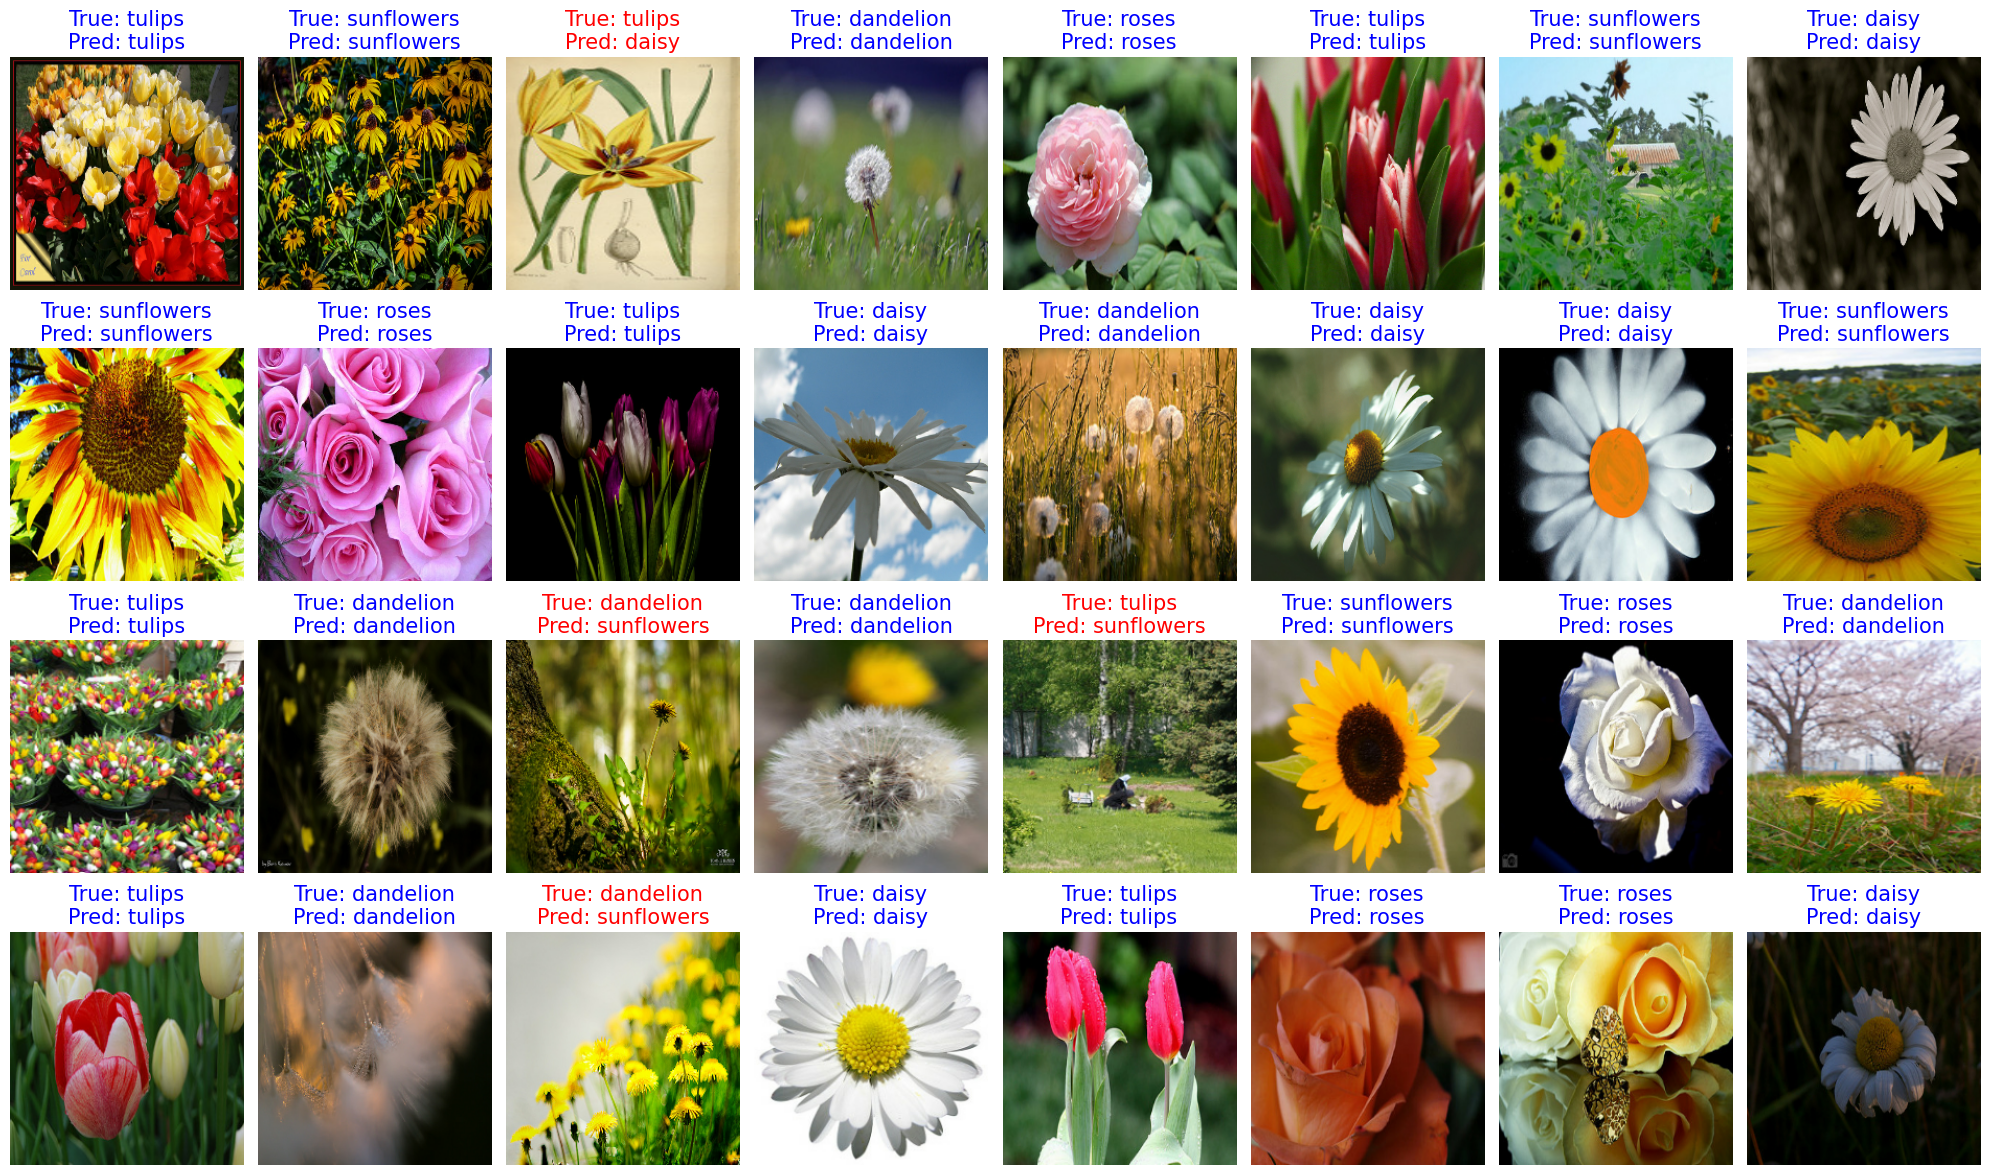

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# 클래스 이름 목록
class_names = train_ds.class_names

# 배치 하나 가져오기 (또는 전체 반복)
for images, labels in test_ds.take(1):  # 한 배치만 예시
    preds = mobilenet_model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)

    plt.figure(figsize=(20, 12))

    for i in range(len(images)):
        ax = plt.subplot(4, 8, i + 1)  # 4행 8열 (최대 32개)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[pred_labels[i]]

        color = 'blue' if pred_label == true_label else 'red'
        title = f"True: {true_label}\nPred: {pred_label}"
        ax.set_title(title, color=color, fontsize=15)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


## 회고


1) 김의훈

- 배운점: 데이터셋을 가지고 모델을 직접 만드는 방법, 학습된 모델을 적용하는 트랜스퍼 러닝을 적용하는 방법을 배울 수 있었다. 그 과정에서 성능을 올릴 수 있는 여러가지 방법(모델 변경, 하이퍼파라미터 튜닝)에 대해서도 배울 수 있었다.

- 아쉬운 점: 모델 성능이 잘 나왔는데 플러터까지 연결하지 못한점이 아쉽다. 

- 느낀 점: 전이학습에서도 전략이 3가지가 있다는 것을 알게되었고, 데이터셋의 크기에 따라 어떤 전략을 써야할 지 생각해보게 되었다. 

- 어려웠던 점: 어쩔때는 성능이 좋게 나오고 어쩔때는 성능이 안좋게 나오는데, 변수가 많아서 그런지 성능에 대한 일정한 패턴을 파악하기가 어렵다.

2) 이윤환

- 배운점: 여전히 성능 개선을 위한 방법들을 잘 모르겠다. 그래도 여러 시도를 해보는 것은 항상 배운다.

- 아쉬운 점: 일관된 성능을 위한 감각이 생기지 않는다.

- 느낀 점: 매번 하이퍼파라미터를 수정만 하는 느낌이다. 전반적인 변화에 대한 이해도가 필요할 것 같다.

- 어려웠던 점: 다양한 코딩 방식이 있기때문에 어떤 것을 선택해야할지 고민이다. 

3) 박지윤

- 모델 성능이 제대로 안 나와서 1차 망함/ 플러터로 구현하려다가 연동이 안 되어서 2차 망함… 윤환님의 하드캐리로 살았다. 

4) 곽현정

- 지난번 dlton 때 했던 과정을 다시 해보는 것이다 보니, 조금은 편하게 느껴지는 프로젝트였다. 다만 vgg16은 당시에 썼던 mobilenet이나 xception 같은 모델보다 성능이 많이 떨어지는 것 같다. 그래도 training accuracy보다 validation accuracy가 더 높은 양상을 보여서 과적합 문제가 해결된 것 같아서 기뻤다 ㅎㅎ 하지만 플러터는 언제나 오류의 범벅… 언제나 느끼지만 구현이 쉽지만은 않은 것 같다..

5) 김선

- vgg16의 feature extractor 부분을 freeze한 상태로 훈련했더니 성능이 그다지 좋지 못했다. 그래서 Conv 블록을 열어서 훈련시켰더니 성능이 92퍼센트 정도까지 도달했다. 데이터셋의 크기에 따라서 하이퍼 파라미터와 이미지 사이즈, 픽셀값 튜닝 방향이 달라지기 때문에 여러 방면으로 시도하고 고찰해야 한다는 것을 깨달았다.  그나저나 플러터는 아직도 적응이 안된다;;🤧

6) 종합 회고

배운 점

- VGG16의 feature extractor 부분을 freeze한 상태로 훈련했더니 성능이 그다지 좋지 못해서 Conv 블록을 열어서 훈련시켰더니 성능이 92퍼센트 정도까지 도달함
- VGG16을 MobileNet으로 바꿨더니 성능과 안정성을 둘 다 잡음
- 그래프에서 val acc가 train acc보다 높고 일정하고 안정적인 곡선을 그림

아쉬운 점

- 모델이 잘 나온것에 비해 플러터가 자꾸 오류가 나서 구현하지 못했다는 점이 아쉬움

느낀 점

- 전이학습에도 여러 전략이 있고, 상황에 따라 유연하게 선택해야 함을 느낌
- 머신러닝 모델의 결과는 다양한 변수에 의해 크게 달라질 수 있어 결과의 일관성을 확보하는 것이 쉽지 않음
- 프로젝트 경험이 쌓일수록 전체적인 흐름을 보는 시야가 넓어졌음을 느낌

어려운점

- 모델 성능이 일정하지 않고 예측 불가능한 경우가 많아 원인 분석이 어려움
- 플러터와 딥러닝 모델을 연동하는 과정에서 기술적 오류가 반복적으로 발생